<a href="https://colab.research.google.com/github/gregoryozaki/exploring-bias-in-deep-learning-gender-and-race-classification-with-balanced-and-biased-datasets/blob/main/fairface_intra_domain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

drive_base_path = '/content/drive/MyDrive/datasets'
celeba_zip_drive = os.path.join(drive_base_path, 'dataset-celeba', 'celeba.zip')
fairface_zip_drive = os.path.join(drive_base_path, 'dataset-fairface', 'fairface.zip')

celeba_zip_local = '/content/celeba.zip'
fairface_zip_local = '/content/fairface.zip'
celeba_extract_path = '/content/celeba'
fairface_extract_path = '/content/fairface'

!cp "{celeba_zip_drive}" "{celeba_zip_local}"
!cp "{fairface_zip_drive}" "{fairface_zip_local}"

def extract_zip(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to, exist_ok=True)
        print(f"Extraindo {zip_path} para {extract_to} ...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print("✅ Extração concluída.")
    else:
        print(f"📂 Já existe a pasta extraída: {extract_to}")

extract_zip(celeba_zip_local, celeba_extract_path)
extract_zip(fairface_zip_local, fairface_extract_path)

fairface_csv_train_drive = '/content/drive/MyDrive/datasets/dataset-fairface/fairface_train.csv'
fairface_csv_val_drive   = '/content/drive/MyDrive/datasets/dataset-fairface/fairface_val.csv'

celeba_csv_train_drive = '/content/drive/MyDrive/datasets/dataset-celeba/celeba_train.csv'
celeba_csv_val_drive   = '/content/drive/MyDrive/datasets/dataset-celeba/celeba_val.csv'

!cp "{celeba_csv_train_drive}" /content/
!cp "{celeba_csv_val_drive}" /content/
!cp "{fairface_csv_train_drive}" /content/
!cp "{fairface_csv_val_drive}" /content/

Mounted at /content/drive
Extraindo /content/celeba.zip para /content/celeba ...
✅ Extração concluída.
Extraindo /content/fairface.zip para /content/fairface ...
✅ Extração concluída.


In [ ]:
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch
import os

class FaceDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.img_dir = img_dir
        self.transform = transform

        # Corrige capitalização
        self.data['gender'] = self.data['gender'].str.lower().str.strip()
        self.data['race'] = self.data['race'].str.lower().str.strip()

        # Mapeamento de classes
        self.gender_map = {'male': 0, 'female': 1}
        self.race_map = {
            'white': 0, 'black': 1, 'indian': 2, 'east asian': 3,
            'southeast asian': 4, 'middle eastern': 5, 'latino_hispanic': 6
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['file'])  # <-- Corrigido aqui
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        gender_label = self.gender_map[row['gender']]
        race_label = self.race_map[row['race']]

        return image, gender_label, race_label

from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
model = convnext_tiny(weights=weights)

transform = weights.transforms()

fairface_train_dataset = FaceDataset('/content/fairface_train.csv', '/content/fairface/fairface', transform)
fairface_val_dataset   = FaceDataset('/content/fairface_val.csv', '/content/fairface/fairface', transform)

from torch.utils.data import DataLoader
from tqdm.notebook import tqdm



batch_size = 64
num_workers = 2

fairface_train_loader = DataLoader(fairface_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers,  pin_memory=True)
fairface_val_loader   = DataLoader(fairface_val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True if torch.cuda.is_available() else False)


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:01<00:00, 75.9MB/s]


In [ ]:
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ConvNeXt_Tiny_Weights

class MultiTaskConvNeXtTiny(nn.Module):
    def __init__(self, pretrained=True):
        super(MultiTaskConvNeXtTiny, self).__init__()

        # Carrega o backbone
        weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1 if pretrained else None
        self.backbone = models.convnext_tiny(weights=weights)

        # Remove a camada final padrão
        self.backbone.classifier = nn.Identity()
        hidden_dim = 768  # Para ConvNeXt-Tiny

        # Cabeça para gênero
        self.gender_head = nn.Sequential(
            nn.Flatten(),  # Corrige o shape
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, 2)
        )

        # Cabeça para raça
        self.race_head = nn.Sequential(
            nn.Flatten(),  # Corrige o shape
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, 7)
        )

    def forward(self, x):
        features = self.backbone(x)  # Saída será [batch_size, 768, 1, 1]
        gender_out = self.gender_head(features)
        race_out = self.race_head(features)
        return gender_out, race_out

# Correto agora
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskConvNeXtTiny(pretrained=True).to(device)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from tqdm.notebook import tqdm

torch.cuda.empty_cache()

# Configurações
epochs = 10
learning_rate = 1e-4

# Funções de perda
loss_fn_gender = nn.CrossEntropyLoss()
loss_fn_race = nn.CrossEntropyLoss()

# Otimizador
optimizer = AdamW(model.parameters(), lr=learning_rate)

# GradScaler para mixed precision
scaler = torch.amp.GradScaler()

# Loop de treino
def train_one_epoch(model, dataloader, optimizer, device, scaler):
    model.train()
    total_loss = 0
    correct_gender = 0
    correct_race = 0
    total = 0

    for images, gender_labels, race_labels in tqdm(dataloader, desc="Treinando"):
        images = images.to(device)
        gender_labels = gender_labels.to(device)
        race_labels = race_labels.to(device)

        optimizer.zero_grad()

        # Mixed precision autocast
        with torch.autocast(device_type='cuda'):
            gender_preds, race_preds = model(images)

            loss_gender = loss_fn_gender(gender_preds, gender_labels)
            loss_race = loss_fn_race(race_preds, race_labels)
            loss = loss_gender + loss_race

        # Escala o loss e faz backward
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        _, gender_predicted = torch.max(gender_preds, 1)
        _, race_predicted = torch.max(race_preds, 1)

        correct_gender += (gender_predicted == gender_labels).sum().item()
        correct_race += (race_predicted == race_labels).sum().item()
        total += gender_labels.size(0)

    avg_loss = total_loss / len(dataloader)
    gender_acc = correct_gender / total
    race_acc = correct_race / total
    return avg_loss, gender_acc, race_acc

# Loop de validação (não precisa mixed precision, mas pode usar autocast para leve ganho de velocidade)
def validate(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct_gender = 0
    correct_race = 0
    total = 0

    with torch.no_grad():
        for images, gender_labels, race_labels in tqdm(dataloader, desc="Validando"):
            images = images.to(device)
            gender_labels = gender_labels.to(device)
            race_labels = race_labels.to(device)

            with torch.autocast(device_type='cuda'):
                gender_preds, race_preds = model(images)

                loss_gender = loss_fn_gender(gender_preds, gender_labels)
                loss_race = loss_fn_race(race_preds, race_labels)
                loss = loss_gender + loss_race

            total_loss += loss.item()

            _, gender_predicted = torch.max(gender_preds, 1)
            _, race_predicted = torch.max(race_preds, 1)

            correct_gender += (gender_predicted == gender_labels).sum().item()
            correct_race += (race_predicted == race_labels).sum().item()
            total += gender_labels.size(0)

    avg_loss = total_loss / len(dataloader)
    gender_acc = correct_gender / total
    race_acc = correct_race / total
    return avg_loss, gender_acc, race_acc

# Treinamento
for epoch in range(epochs):
    print(f"\n🌟 Época {epoch+1}/{epochs}")

    train_loss, train_gender_acc, train_race_acc = train_one_epoch(model, fairface_train_loader, optimizer, device, scaler)
    val_loss, val_gender_acc, val_race_acc = validate(model, fairface_val_loader, device)

    print(f"🧠 Treino — Loss: {train_loss:.4f}, Gênero Acc: {train_gender_acc:.4f}, Raça Acc: {train_race_acc:.4f}")
    print(f"🔍 Validação — Loss: {val_loss:.4f}, Gênero Acc: {val_gender_acc:.4f}, Raça Acc: {val_race_acc:.4f}")


🌟 Época 1/10


Treinando:   0%|          | 0/1329 [00:00<?, ?it/s]

Validando:   0%|          | 0/157 [00:00<?, ?it/s]

🧠 Treino — Loss: 1.2977, Gênero Acc: 0.8899, Raça Acc: 0.6005
🔍 Validação — Loss: 1.0783, Gênero Acc: 0.9265, Raça Acc: 0.6544

🌟 Época 2/10


Treinando:   0%|          | 0/1329 [00:00<?, ?it/s]

Validando:   0%|          | 0/157 [00:00<?, ?it/s]

🧠 Treino — Loss: 0.9046, Gênero Acc: 0.9409, Raça Acc: 0.7136
🔍 Validação — Loss: 1.0204, Gênero Acc: 0.9278, Raça Acc: 0.6855

🌟 Época 3/10


Treinando:   0%|          | 0/1329 [00:00<?, ?it/s]

Validando:   0%|          | 0/157 [00:00<?, ?it/s]

🧠 Treino — Loss: 0.6761, Gênero Acc: 0.9634, Raça Acc: 0.7834
🔍 Validação — Loss: 1.0267, Gênero Acc: 0.9264, Raça Acc: 0.6949

🌟 Época 4/10


Treinando:   0%|          | 0/1329 [00:00<?, ?it/s]

Validando:   0%|          | 0/157 [00:00<?, ?it/s]

🧠 Treino — Loss: 0.4594, Gênero Acc: 0.9806, Raça Acc: 0.8521
🔍 Validação — Loss: 1.1642, Gênero Acc: 0.9297, Raça Acc: 0.6893

🌟 Época 5/10


Treinando:   0%|          | 0/1329 [00:00<?, ?it/s]

Validando:   0%|          | 0/157 [00:00<?, ?it/s]

🧠 Treino — Loss: 0.2924, Gênero Acc: 0.9872, Raça Acc: 0.9095
🔍 Validação — Loss: 1.4269, Gênero Acc: 0.9178, Raça Acc: 0.6876

🌟 Época 6/10


Treinando:   0%|          | 0/1329 [00:00<?, ?it/s]

Validando:   0%|          | 0/157 [00:00<?, ?it/s]

🧠 Treino — Loss: 0.2066, Gênero Acc: 0.9900, Raça Acc: 0.9377
🔍 Validação — Loss: 1.4800, Gênero Acc: 0.9291, Raça Acc: 0.6770

🌟 Época 7/10


Treinando:   0%|          | 0/1329 [00:00<?, ?it/s]

Validando:   0%|          | 0/157 [00:00<?, ?it/s]

🧠 Treino — Loss: 0.1649, Gênero Acc: 0.9908, Raça Acc: 0.9511
🔍 Validação — Loss: 1.5928, Gênero Acc: 0.9274, Raça Acc: 0.6819

🌟 Época 8/10


Treinando:   0%|          | 0/1329 [00:00<?, ?it/s]

Validando:   0%|          | 0/157 [00:00<?, ?it/s]

🧠 Treino — Loss: 0.1409, Gênero Acc: 0.9920, Raça Acc: 0.9589
🔍 Validação — Loss: 1.7346, Gênero Acc: 0.9289, Raça Acc: 0.6764

🌟 Época 9/10


Treinando:   0%|          | 0/1329 [00:00<?, ?it/s]

Validando:   0%|          | 0/157 [00:00<?, ?it/s]

🧠 Treino — Loss: 0.1308, Gênero Acc: 0.9922, Raça Acc: 0.9620
🔍 Validação — Loss: 1.8412, Gênero Acc: 0.9242, Raça Acc: 0.6643

🌟 Época 10/10


Treinando:   0%|          | 0/1329 [00:00<?, ?it/s]

Validando:   0%|          | 0/157 [00:00<?, ?it/s]

🧠 Treino — Loss: 0.1231, Gênero Acc: 0.9930, Raça Acc: 0.9641
🔍 Validação — Loss: 1.7936, Gênero Acc: 0.9267, Raça Acc: 0.6826


In [ ]:
from sklearn.metrics import classification_report

# Listas globais para armazenar previsões e rótulos
all_gender_preds = []
all_gender_labels = []
all_race_preds = []
all_race_labels = []

gender_classes = ["Homem", "Mulher"]
race_classes = ["White", "Black", "Latino_Hispanic", "East Asian", "Southeast Asian", "Indian", "Middle Eastern"]

def validate(model, dataloader, device):
    model.eval()
    total_loss = 0
    correct_gender = 0
    correct_race = 0
    total = 0

    # Limpa as listas globais
    global all_gender_preds, all_gender_labels, all_race_preds, all_race_labels
    all_gender_preds = []
    all_gender_labels = []
    all_race_preds = []
    all_race_labels = []

    with torch.no_grad():
        for images, gender_labels, race_labels in tqdm(dataloader, desc="Validando (métricas)"):
            images = images.to(device)
            gender_labels = gender_labels.to(device)
            race_labels = race_labels.to(device)

            gender_preds, race_preds = model(images)

            loss_gender = loss_fn_gender(gender_preds, gender_labels)
            loss_race = loss_fn_race(race_preds, race_labels)
            loss = loss_gender + loss_race

            total_loss += loss.item()
            _, gender_predicted = torch.max(gender_preds, 1)
            _, race_predicted = torch.max(race_preds, 1)

            correct_gender += (gender_predicted == gender_labels).sum().item()
            correct_race += (race_predicted == race_labels).sum().item()
            total += gender_labels.size(0)

            all_gender_labels.extend(gender_labels.cpu().numpy())
            all_gender_preds.extend(gender_predicted.cpu().numpy())
            all_race_labels.extend(race_labels.cpu().numpy())
            all_race_preds.extend(race_predicted.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    gender_acc = correct_gender / total
    race_acc = correct_race / total
    return avg_loss, gender_acc, race_acc


In [ ]:
# Executa a validação final
validate(model, fairface_val_loader, device)

# Relatórios
print("\n📊 Relatório de Classificação - Gênero")
print(classification_report(all_gender_labels, all_gender_preds, target_names=gender_classes))

print("\n📊 Relatório de Classificação - Raça")
print(classification_report(all_race_labels, all_race_preds, target_names=race_classes))


Validando (métricas):   0%|          | 0/157 [00:00<?, ?it/s]


📊 Relatório de Classificação - Gênero
              precision    recall  f1-score   support

       Homem       0.93      0.94      0.93      5307
      Mulher       0.93      0.92      0.92      4693

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000


📊 Relatório de Classificação - Raça
                 precision    recall  f1-score   support

          White       0.74      0.73      0.73      1910
          Black       0.87      0.85      0.86      1406
Latino_Hispanic       0.69      0.72      0.71      1373
     East Asian       0.72      0.67      0.69      1437
Southeast Asian       0.61      0.58      0.60      1291
         Indian       0.66      0.63      0.64      1104
 Middle Eastern       0.50      0.56      0.53      1479

       accuracy                           0.68     10000
      macro avg       0.68      0.68      0.68     10000
   weighted avg       0.6

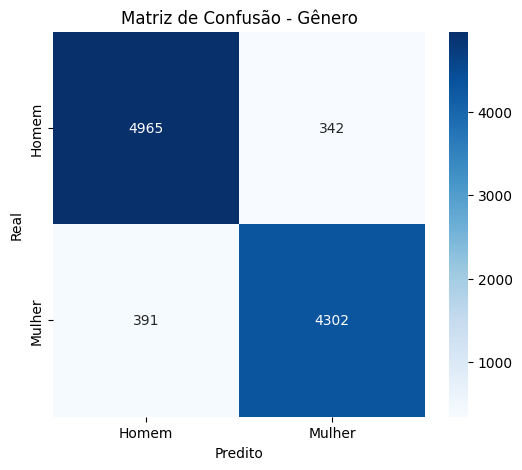

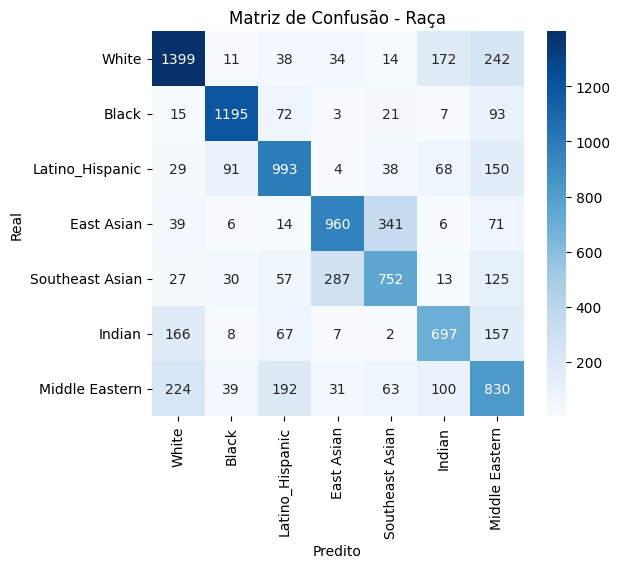

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Função para plotar a matriz de confusão
def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

# Matriz de confusão para Gênero
plot_confusion_matrix(all_gender_labels, all_gender_preds, gender_classes, "Matriz de Confusão - Gênero")

# Matriz de confusão para Raça (pode ser maior)
plot_confusion_matrix(all_race_labels, all_race_preds, race_classes, "Matriz de Confusão - Raça")

In [ ]:
# Salva os pesos
torch.save(model.state_dict(), "modelo_fairface_10epocas.pth")
from google.colab import files
files.download("modelo_fairface_10epocas.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>